In [1]:
import sys
import os

# Adjust the sys.path to include the src directory
current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '../..', '')))
print("Path setup complete.")

Path setup complete.


In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import json 
from matplotlib import rc
import pandas as pd

import yads.mesh as ym

# rc("text", usetex=True)
rc("font", **{"family": "serif", "size": 12})
rc("figure", **{"figsize": (5, 3)})

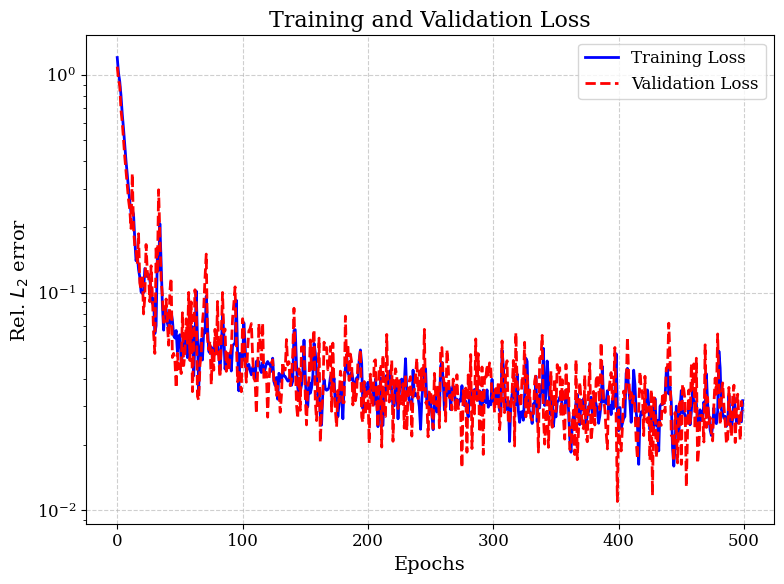

In [3]:
def loss_plot():
    with open("hybrid_newton_data/GWM_loss_dict_500.pkl", 'rb') as f:
        loss_dict = pickle.load(f)

    # Extract training and validation losses
    train_loss = loss_dict['train_loss']
    val_loss = loss_dict['val_loss']

    # Plot the loss data
    plt.figure(figsize=(8, 6))
    plt.plot(train_loss, label='Training Loss', color='blue', linestyle='-', linewidth=2)
    plt.plot(val_loss, label='Validation Loss', color='red', linestyle='--', linewidth=2)

    # Add titles and labels
    plt.title('Training and Validation Loss', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Rel. $L_2$ error', fontsize=14)

    # Add grid, legend, and style
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='upper right', fontsize=12)
    plt.yscale('log')
    # Show the plot
    plt.tight_layout()
    plt.savefig('loss.pdf', dpi=500)
    plt.show()  
    return 

loss_plot()

In [4]:
def plot_P_S(json_path, figures_save_path):
    with open(json_path, "r") as f:
        states = json.load(f)
    
    sim_data = states["newton_step_data"]
    centers = np.linspace(0.5, 200.5, 201)

    # figure
    for step in sim_data.keys():
        fig = plt.figure(figsize=(12, 12))
        ax1 = plt.subplot(2, 2, 1)
        ax2 = plt.subplot(2, 2, 2)
        ax3 = plt.subplot(2, 2, 3)
        ax4 = plt.subplot(2, 2, 4)

        ax1.scatter(centers, sim_data[step]["P_i_plus_1"], s=1)
        ax2.scatter(centers, sim_data[step]["S_i_plus_1"], s=1)
        ax3.scatter(centers, sim_data[step]["Residual"][len(centers) :], s=1)
        ax4.scatter(centers, sim_data[step]["Residual"][: len(centers)], s=1)

        R_p = np.linalg.norm(sim_data[step]["Residual"][len(centers) :], ord=2)
        R_s = np.linalg.norm(sim_data[step]["Residual"][: len(centers)], ord=2)
        ax1.title.set_text("Pressure through the domain")
        ax2.title.set_text("Saturation through the domain")
        ax3.title.set_text(f"Pressure residual through the domain\n norm={R_p:0.2E}")
        ax4.title.set_text(f"Water residual through the domain\n norm={R_s:0.2E}")

        ax2.set_ylim([-0.1, 1.1])

        ax1.set(ylabel="P", xlabel="x")
        ax2.set(ylabel="S", xlabel="x")
        ax3.set(ylabel="Pressure residual", xlabel="x")
        ax4.set(ylabel="Water residual", xlabel="x")

        plt.savefig(figures_save_path + "_" + str(step), dpi=150)
        plt.close(fig)
    return

In [16]:
i = 0

In [37]:
os.makedirs("hybrid_newton_example", exist_ok=True)
plot_P_S(
        f"results/test_classic_{i}.json",
        "hybrid_newton_example/test_hybrid",
    )
print(i)
i+=1

19


In [22]:
print(i)

5


In [ ]:
# nice i values: 5, 19

In [23]:
def specific_plot(i):

    df = pd.read_csv(
            f"./results/test_{i}.csv",
            sep="\t",
        )
    
    dt = df['total_sim_time'].values
    grid = ym.two_D.create_2d_cartesian(50 * 200, 1000, 201, 1)
    V = grid.measures(item="cell")


    with open(f"results/test_classic_{i}.json", "r") as f:
        classic_states = json.load(f)
    

    
    sim_data = classic_states["newton_step_data"]
    
    classic_residuals = []
    
    for step in sim_data.keys():
        B = np.array(sim_data[step]['Residual'])
        classic_residuals.append(np.max(np.abs(B) * dt / np.concatenate([V, V])))

    classic_steps = list(range(1, len(classic_residuals) + 1))

    steps_to_plot = ['1', '10', '20', '30', '48'] 

    # Classic plots
    # Create subplots
    plt.rcParams.update({'xtick.labelsize':16, 'ytick.labelsize':16})
    fig, axs = plt.subplots(1, 3, figsize=(24, 8))

    # Plot P_i_plus_1
    for step in steps_to_plot:
        if step in sim_data.keys():
            P_i_plus_1 = sim_data[step]["P_i_plus_1"]
            axs[0].plot(P_i_plus_1, label=f"Step {step}")
        else:
            print(f"Step {step} not found in simulation data")
    axs[0].set_ylabel("P", fontsize=20, fontweight='bold')
    axs[0].set_title("Evolution of Pressure through Newton Iterates", fontsize=20)
    axs[0].legend(fontsize=20)
    axs[0].grid(True)

    # Plot S_i_plus_1
    for step in steps_to_plot:
        if step in sim_data.keys():
            S_i_plus_1 = sim_data[step]["S_i_plus_1"]
            axs[1].plot(S_i_plus_1, label=f"Step {step}")
        else:
            print(f"Step {step} not found in simulation data")

    
    axs[1].set_ylabel("S", fontsize=20, fontweight='bold')
    axs[1].set_title("Evolution of Saturation through Newton Iterates", fontsize=20)
    axs[1].legend(fontsize=20)
    axs[1].grid(True)
    
    
    axs[2].set_yscale("log")
    

    for step in steps_to_plot:
        axs[2].scatter(int(step) , classic_residuals[int(step) - 1], label=f"Step {step}", marker='X', s = 250)
    
    axs[2].scatter(classic_steps, classic_residuals)
    axs[2].set_xlabel("Newton iterates", fontsize=20, fontweight='bold')
    axs[2].set_ylabel("Residual", fontsize=20, fontweight='bold')
    axs[2].set_title("Evolution of Residual through Newton Iterates", fontsize=20)

    axs[2].legend(fontsize=20)
    axs[2].grid(True)
    
    plt.tight_layout()
    plt.savefig(f"classic_newton_sample_{i}.pdf", dpi=500)

    plt.show()

    # Hybrid Plots

    steps_to_plot = ['1', '2', '3']

    with open(f"results/test_hybrid_{i}.json", "r") as f:
        hybrid_states = json.load(f)

    sim_data = hybrid_states["newton_step_data"]
    
    hybrid_residuals = []
    
    for step in sim_data.keys():
        B = np.array(sim_data[step]['Residual'])
        hybrid_residuals.append(np.max(np.abs(B) * dt / np.concatenate([V, V])))

    hybrid_steps = list(range(1, len(hybrid_residuals) + 1))

    fig, axs = plt.subplots(1, 3, figsize=(24, 8))

    # Plot P_i_plus_1
    for step in steps_to_plot:
        if step in sim_data.keys():
            P_i_plus_1 = sim_data[step]["P_i_plus_1"]
            axs[0].plot(P_i_plus_1, label=f"Step {step}")
        else:
            print(f"Step {step} not found in simulation data")
    axs[0].set_ylabel("P", fontsize=20, fontweight='bold')
    axs[0].set_title("Evolution of Pressure through Newton Iterates", fontsize=20)
    axs[0].legend(fontsize=20)
    axs[0].grid(True)

    # Plot S_i_plus_1
    for step in steps_to_plot:
        if step in sim_data.keys():
            S_i_plus_1 = sim_data[step]["S_i_plus_1"]
            axs[1].plot(S_i_plus_1, label=f"Step {step}")
        else:
            print(f"Step {step} not found in simulation data")

    
    axs[1].set_ylabel("S", fontsize=20, fontweight='bold')
    axs[1].set_title("Evolution of Saturation through Newton Iterates", fontsize=20)
    axs[1].legend(fontsize=20)
    axs[1].grid(True)
    
    
    axs[2].set_yscale("log")
    

    for step in steps_to_plot:
        axs[2].scatter(int(step) , hybrid_residuals[int(step) - 1], label=f"Step {step}", marker='X', s = 250)
    
    axs[2].scatter(hybrid_steps, hybrid_residuals)

    axs[2].set_xlabel("Newton iterates", fontsize=20, fontweight='bold')
    axs[2].set_ylabel("Residual", fontsize=20, fontweight='bold')
    axs[2].set_title("Evolution of Residual through Newton Iterates", fontsize=20)

    axs[2].legend(fontsize=20)
    axs[2].grid(True)
    
    plt.tight_layout()
    plt.savefig(f"hybrid_newton_sample_{i}.pdf", dpi=500)
    plt.show()
    return 


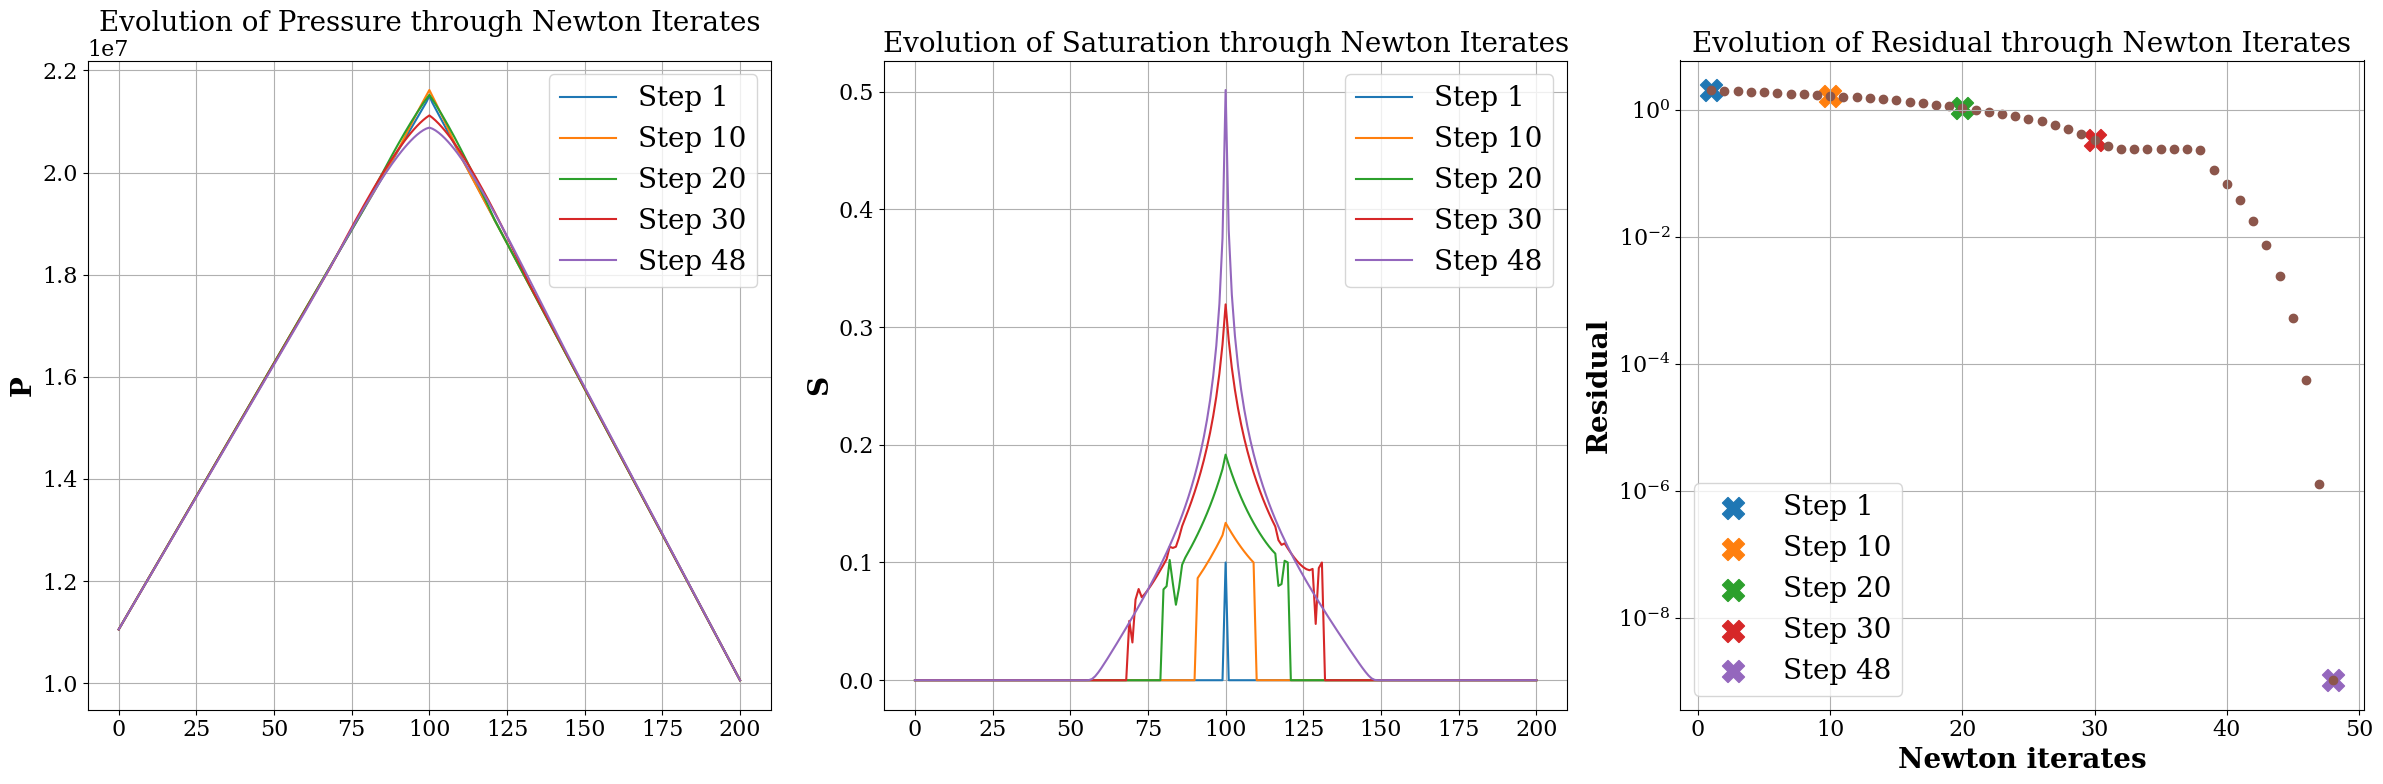

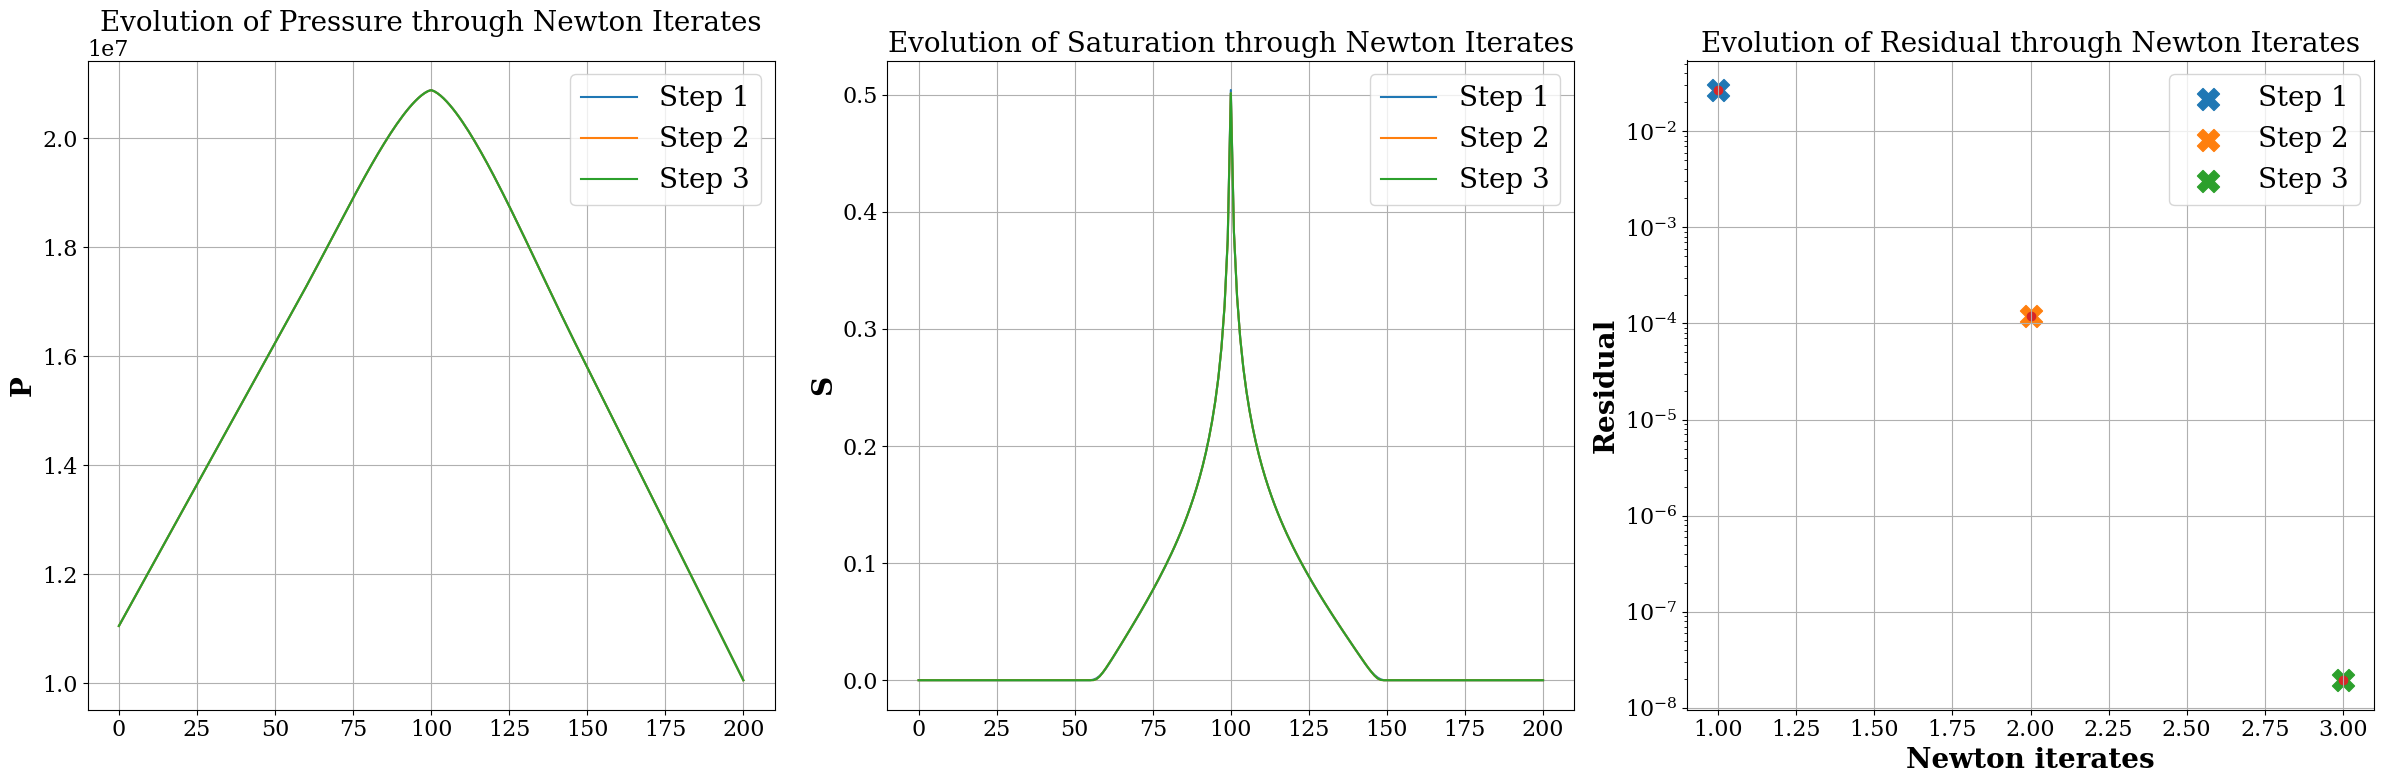

In [24]:
specific_plot(19)